In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
import numba as nb
from time import time

## Meshgrid

In [2]:
n_grid = 512
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(0,0,1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 


## Random wave functions

In [3]:
def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)

#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8, seed=None):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    np.random.seed(seed)

    for i in range(n_wave):
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        phi_r = np.random.rand()*2*np.pi # random phase
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi_r) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

## Visualization

### Functions

In [4]:
def plot_singleclipping(ax,sigma_k,kappa,alpha,seed=None,scale=5):
    ## Wave vector distribution
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
    rho_binary = np.zeros_like(rho)
    rho_binary[rho>=alpha] = 1

    print("Volume feaction = {}".format(np.sum(rho_binary)/np.sum(np.ones_like(rho_binary))))

    # pcolor
    ax.pcolormesh(r_grid[0][0,:,:], r_grid[2][0,:,:], rho_binary[0,:,:], #vmin=-1, vmax=2, 
                shading='gouraud',cmap='gray')

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_xticks([])
    ax.set_yticks([])

def plot_doubleclipping(ax, sigma_k,kappa,alpha,seed=None,scale=5):
    ## Wave vector distribution
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
    rho_binary = np.zeros_like(rho)
    rho_binary[rho**2>=alpha**2] = 1

    print("Volume feaction = {}".format(np.sum(rho_binary)/np.sum(np.ones_like(rho_binary))))

    # pcolor
    ax.pcolormesh(r_grid[0][0,:,:], r_grid[2][0,:,:], rho_binary[0,:,:], #vmin=-1, vmax=2, 
                shading='gouraud',cmap='gray')

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_xticks([])
    ax.set_yticks([])

from scipy.special import erfinv
def alpha_phi(phi):
    return (erfinv(phi)-erfinv(-phi))/2*np.sqrt(2)

def plot_contourf(ax, sigma_k,kappa,alpha,
                  seed=None,scale=5,
                  colors=None, alpha_list=[-alpha_phi(0.5),-alpha_phi(0.25),0,alpha_phi(0.25),alpha_phi(0.5)], 
                  ):
    ## Wave vector distribution
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
    rho_binary = np.zeros_like(rho)
    rho_binary[rho>=alpha] = 1

    print("Volume feaction = {}".format(np.sum(rho_binary)/np.sum(np.ones_like(rho_binary))))

    # pcolor
    ax.contourf(r_grid[0][0,:,:], r_grid[2][0,:,:], rho[0,:,:], alpha_list, 
                extend='both', colors=colors
                )

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_xticks([])
    ax.set_yticks([])

def plot_contour(ax, sigma_k,kappa,alpha,
                 seed=None,scale=5,
                 sty='-', lw=0.5, color='k'
                ):
    ## Wave vector distribution
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
    rho_binary = np.zeros_like(rho)
    rho_binary[rho>=alpha] = 1

    print("Volume feaction = {}".format(np.sum(rho_binary)/np.sum(np.ones_like(rho_binary))))

    # pcolor
    ax.contour(r_grid[0][0,:,:], r_grid[2][0,:,:], rho[0,:,:], [alpha], 
            colors=color, linewidths=lw, linestyles=sty
            )

    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_xticks([])
    ax.set_yticks([])

### Binary map

Volume feaction = 0.5531654564177392
Volume feaction = 0.4965896439170267


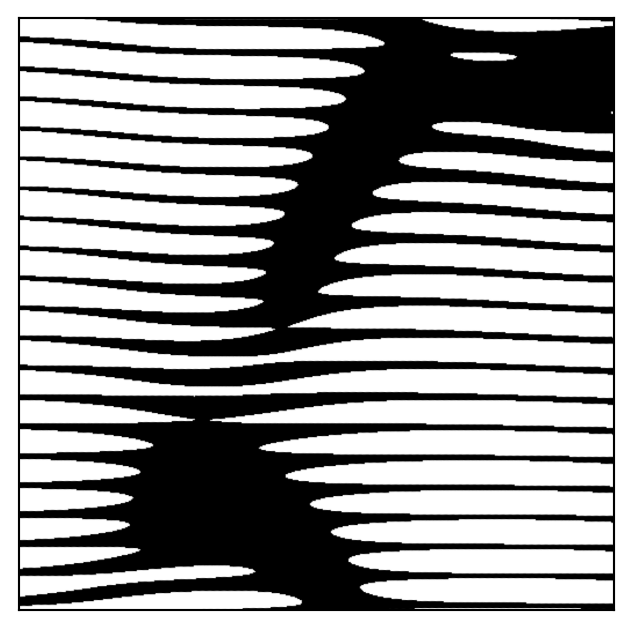

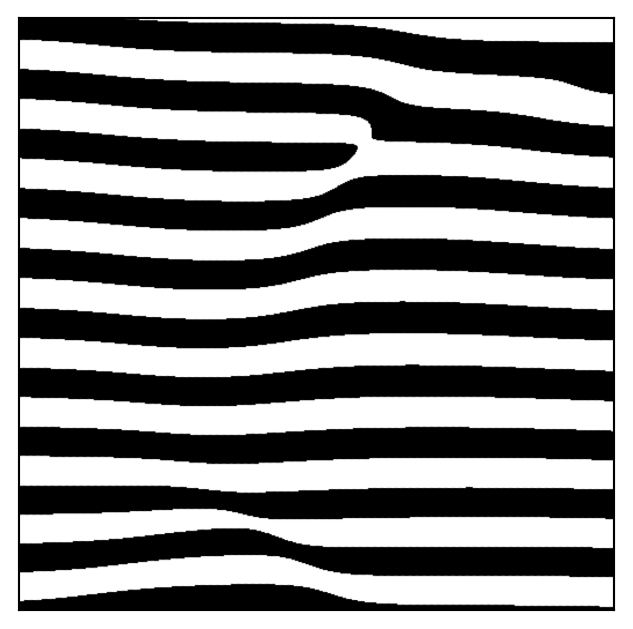

In [35]:
## anisotropic
sigma_k = 0.05
kappa = 128
alpha = 0
phi = 0.5
alpha_double = alpha_phi(phi)

fig = plt.figure(figsize=(4,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

plot_doubleclipping(ax, sigma_k, kappa, alpha_double, scale=5, seed=2023121021)

fig = plt.figure(figsize=(4,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

plot_singleclipping(ax, sigma_k, kappa, alpha, scale=5, seed=2023121021)

Volume feaction = 0.4959474710167231
Volume feaction = 0.4882451960527266


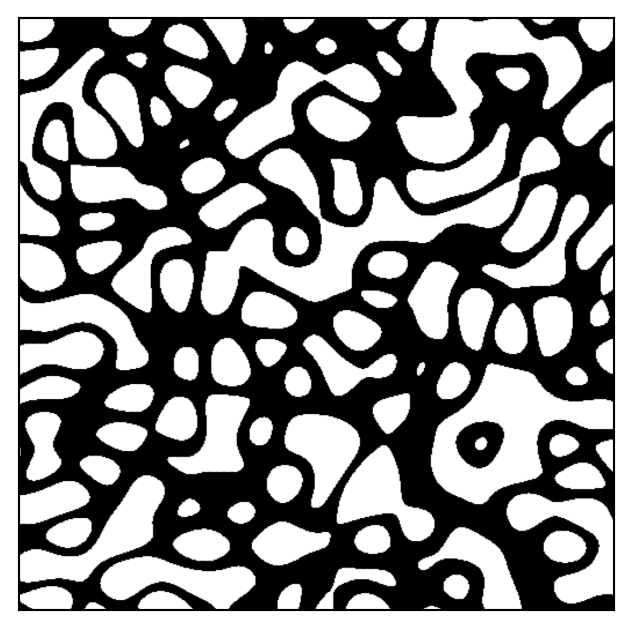

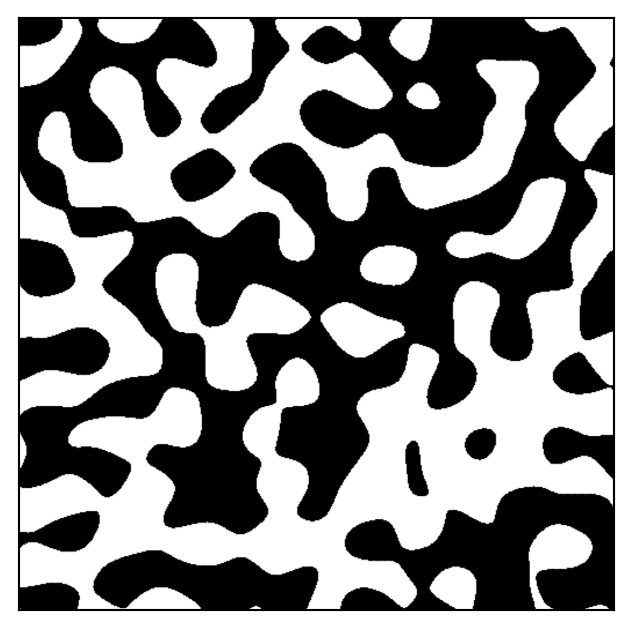

In [6]:
## isotropic
sigma_k = 0.05
kappa = 0.25
alpha = 0
phi = 0.5
alpha_double = alpha_phi(phi)

fig = plt.figure(figsize=(4,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

plot_doubleclipping(ax, sigma_k, kappa, alpha_double, scale=5, seed=114514)

fig = plt.figure(figsize=(4,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

plot_singleclipping(ax, sigma_k, kappa, alpha, scale=5, seed=114514)

### Contours

Volume feaction = 0.5186477130665086
Volume feaction = 0.5186477130665086


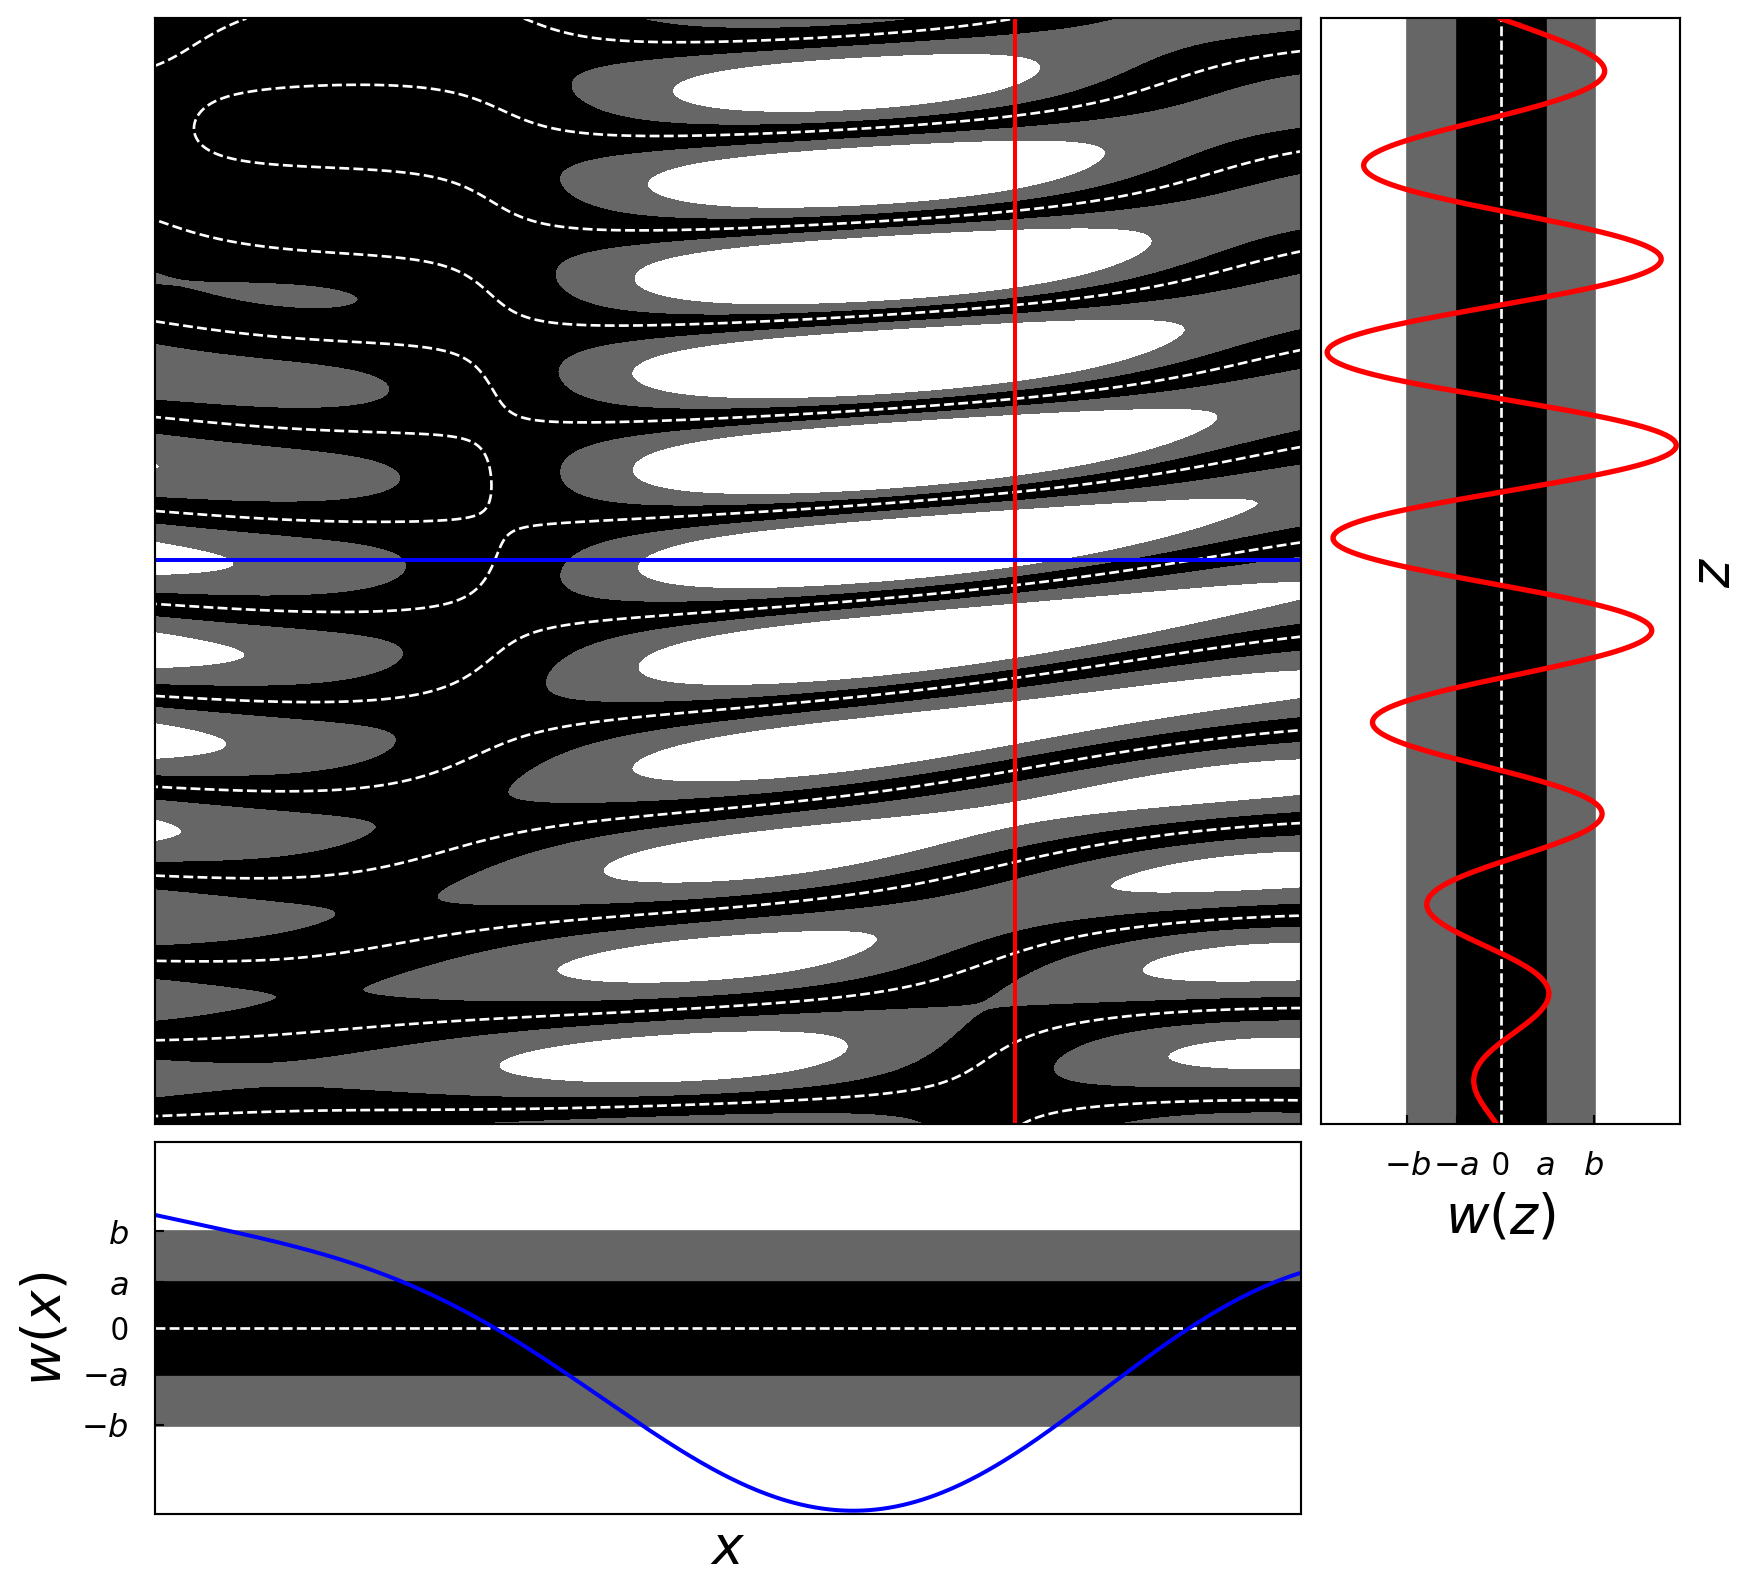

In [39]:
## anisotropic
sigma_k = 0.05
kappa = 128
alpha = 0
phi = 0.5
alpha_double = alpha_phi(phi)
seed = 11451
alpha_list = [-alpha_phi(0.5),-alpha_phi(0.25),alpha_phi(0.25),alpha_phi(0.5)]
scale = 3

sty = '-'
lw = 0.5
color = 'k'

fig = plt.figure(figsize=(11,10),dpi=192)
ax = fig.add_subplot(2, 2, 1)

plot_contourf(ax, sigma_k,kappa,alpha,
              seed=seed, scale=scale,
              alpha_list=alpha_list, colors=['w','#666666','k','#666666','w'])

plot_contour(ax, sigma_k,kappa,alpha=0,
             seed=seed, scale=scale,
             sty='--', color='w', lw=1)

z_pos = 0.02
x_pos = 0.5
ax.plot([x_pos,x_pos],[-2,2],'r')
ax.plot([-2,2],[z_pos,z_pos],'b')

# #cross section
# sigma_k = 0.05
# kappa = 128
# alpha = 0
# phi = 0.5
# alpha_double = alpha_phi(phi)
# scale = 3
# seed = 11451

k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)

## z
i_x = np.round(512*(x_pos-(-1))/(1-(-1))).astype(int)
rho_line = rho[0,i_x,:]

ax = fig.add_subplot(2, 2, 2)

ax.plot(np.zeros_like(x),x,'--w', lw=1)
ax.axvspan(-alpha_phi(0.5), alpha_phi(0.5), alpha=1, color='#666666')
ax.axvspan(-alpha_phi(0.25), alpha_phi(0.25), alpha=1, color='k')
ax.plot(rho_line,x,'r',lw=2)

ax.set_xlim([-1.3,1.3])
ax.set_ylim([-1,1])
ax.set_xticks([-alpha_phi(0.5),-alpha_phi(0.25),0,alpha_phi(0.25),alpha_phi(0.5)])
ax.set_xticklabels(['$-b$','$-a$',0,'$a$','$b$'])
ax.set_yticks([])
ax.set_aspect(4)

ax.set_ylabel(r'$z$', fontsize=20)
ax.yaxis.set_label_position("right")
ax.set_xlabel(r'$w(z)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=12, pad=10)

## x
i_z = np.round(512*(z_pos-(-1))/(1-(-1))).astype(int)
rho_line = rho[0,:,i_z]

ax = fig.add_subplot(2, 2, 3)

ax.plot(z,np.zeros_like(z),'--w', lw=1)
ax.axhspan(-alpha_phi(0.5), alpha_phi(0.5), alpha=1, color='#666666')
ax.axhspan(-alpha_phi(0.25), alpha_phi(0.25), alpha=1, color='k')
ax.plot(z,rho_line,'b')

ax.set_ylim([-1.3,1.3])
ax.set_xlim([-1,1])
ax.set_xticks([])
ax.set_yticks([-alpha_phi(0.5),-alpha_phi(0.25),0,alpha_phi(0.25),alpha_phi(0.5)])
ax.set_yticklabels(['$-b$','$-a$',0,'$a$','$b$'])
ax.set_aspect(1/4)

ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$w(x)$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=12, pad=10)

plt.tight_layout(w_pad=-14,h_pad=-17.5)

Volume feaction = 0.5142702977934331
Volume feaction = 0.5142702977934331
Volume feaction = 0.5142702977934331


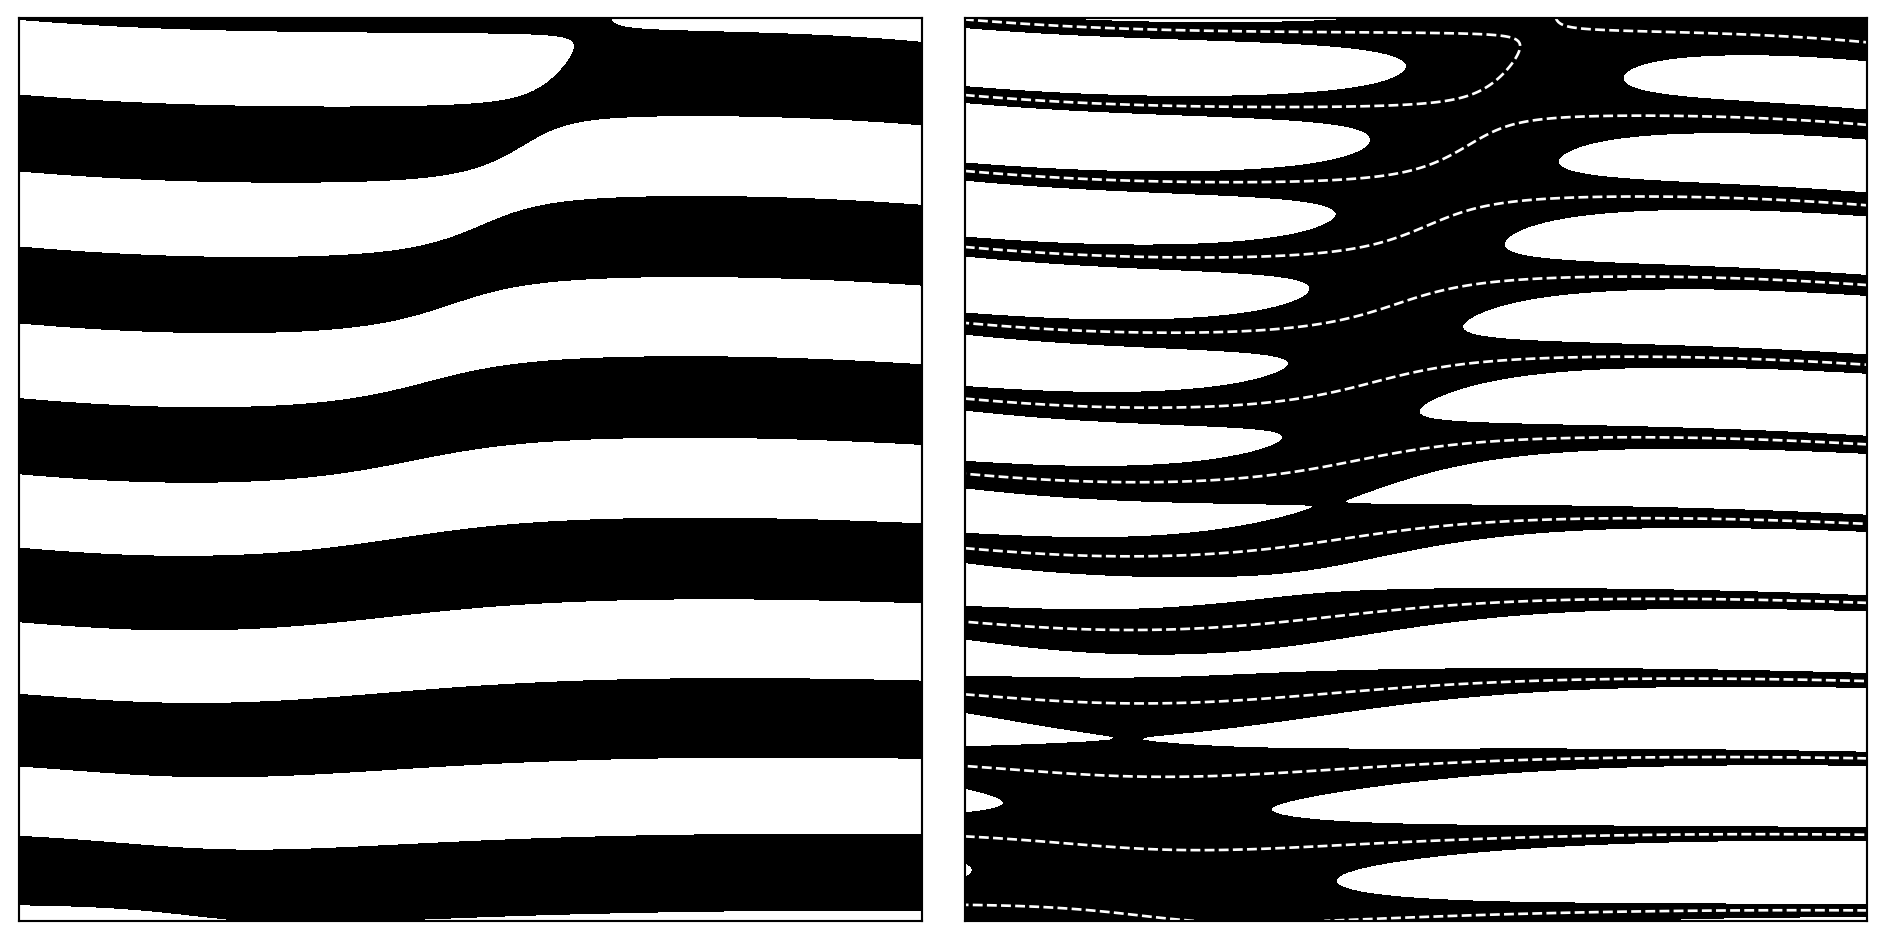

In [33]:
sigma_k = 0.05
kappa = 128
alpha = 0
seed=2023121021
scale = 3

alpha_list_double = [-alpha_phi(0.5),alpha_phi(0.5)]
alpha_list_single = [-100,0,100]

fig = plt.figure(figsize=(10,5),dpi=192)
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect(1)

plot_contourf(ax, sigma_k,kappa,alpha,
              seed=seed, scale=scale,
              alpha_list=alpha_list_single, colors=['w','w','k','w'])

# plot_contour(ax, sigma_k,kappa,alpha=0,
#              seed=seed, scale=5,
#              sty='--', color='w', lw=1)

ax = fig.add_subplot(1, 2, 2)
ax.set_aspect(1)

plot_contourf(ax, sigma_k,kappa,alpha,
              seed=seed, scale=scale,
              alpha_list=alpha_list_double, colors=['w','k','w'])

plot_contour(ax, sigma_k,kappa,alpha=0,
             seed=seed, scale=scale,
             sty='--', color='w', lw=1)

plt.tight_layout()

Volume feaction = 0.5073849883534914
Volume feaction = 0.5073849883534914
Volume feaction = 0.5073849883534914


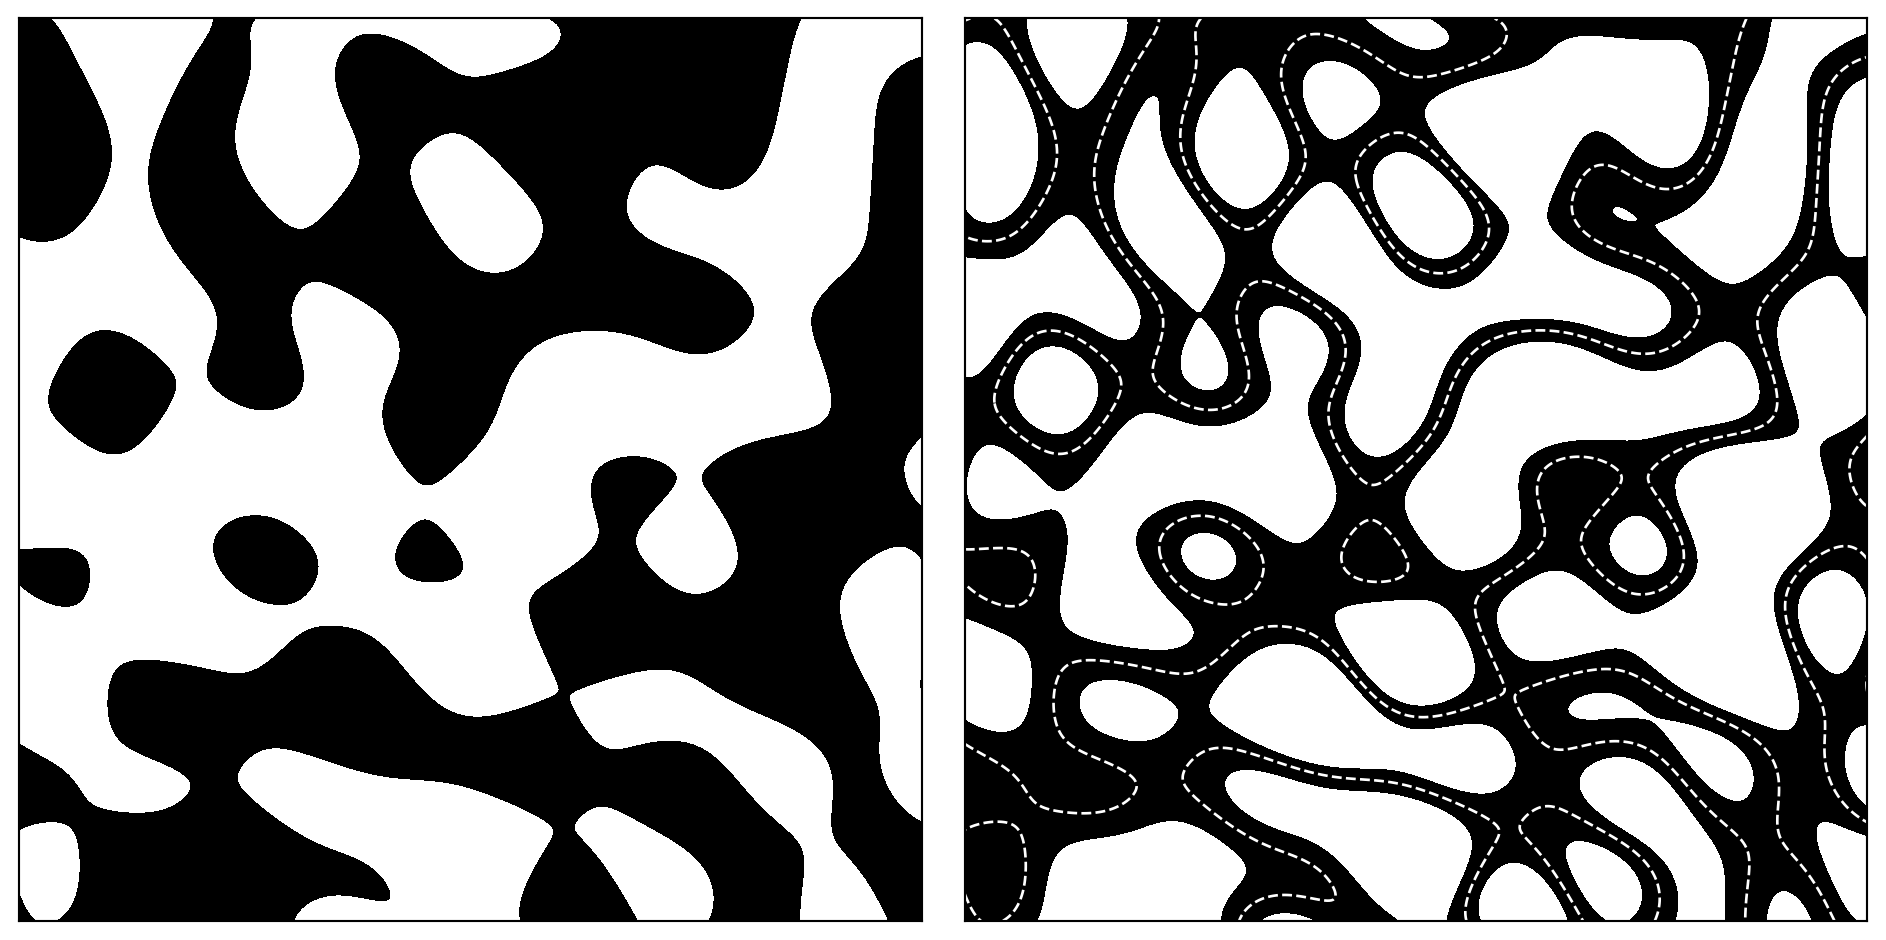

In [34]:
sigma_k = 0.05
kappa = 0.25
alpha = 0
seed=2023121021
scale = 3

alpha_list_double = [-alpha_phi(0.5),alpha_phi(0.5)]
alpha_list_single = [-100,0,100]

fig = plt.figure(figsize=(10,5),dpi=192)
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect(1)

plot_contourf(ax, sigma_k,kappa,alpha,
              seed=seed, scale=scale,
              alpha_list=alpha_list_single, colors=['w','w','k','w'])

# plot_contour(ax, sigma_k,kappa,alpha=0,
#              seed=seed, scale=5,
#              sty='--', color='w', lw=1)

ax = fig.add_subplot(1, 2, 2)
ax.set_aspect(1)

plot_contourf(ax, sigma_k,kappa,alpha,
              seed=seed, scale=scale,
              alpha_list=alpha_list_double, colors=['w','k','w'])

plot_contour(ax, sigma_k,kappa,alpha=0,
             seed=seed, scale=scale,
             sty='--', color='w', lw=1)

plt.tight_layout()

### Cross-section

Text(0, 0.5, '$w(x)$')

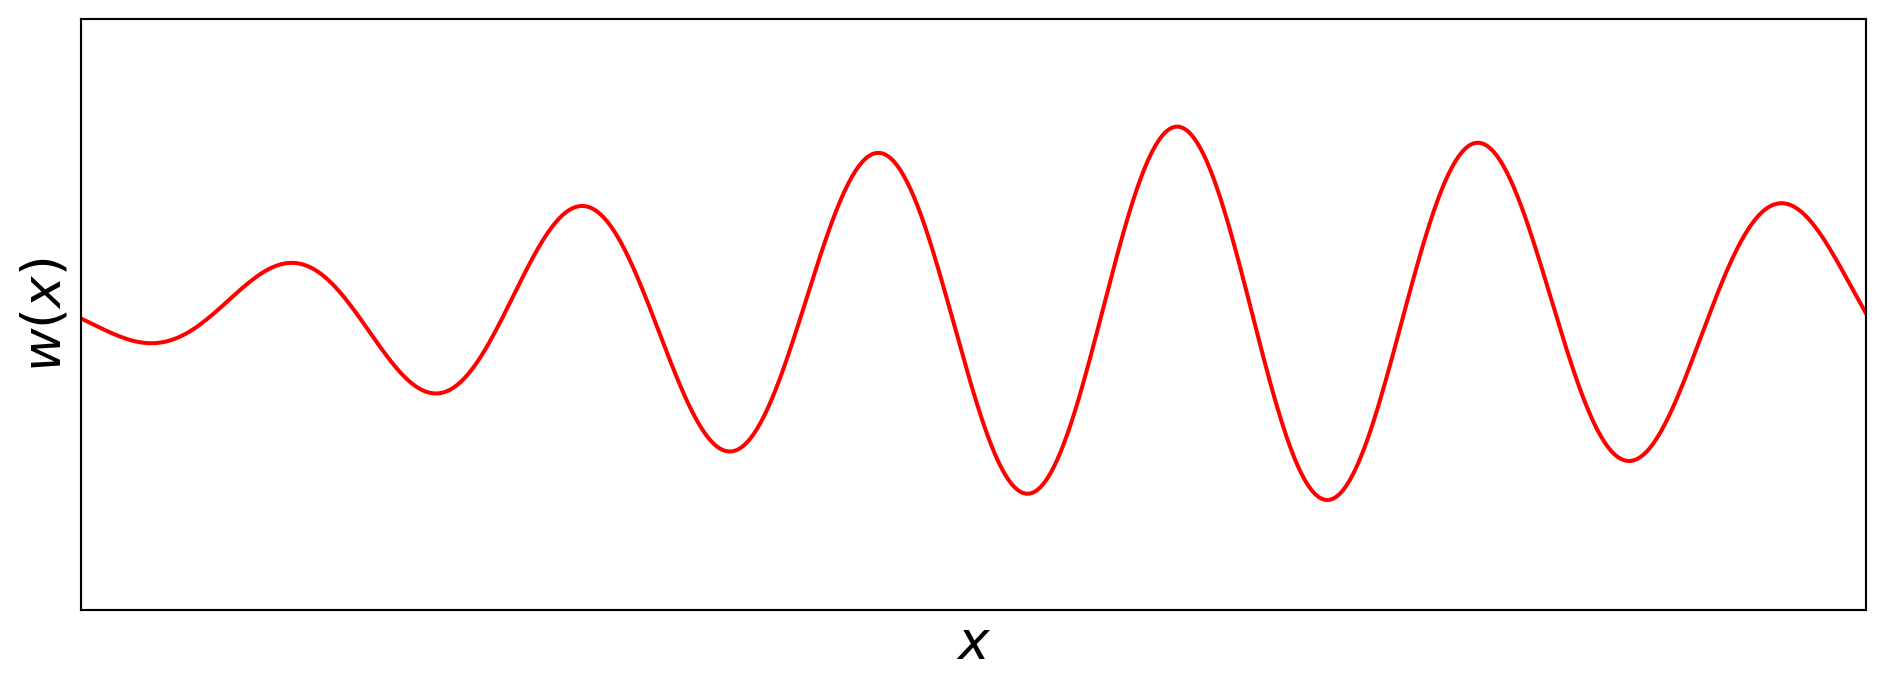

In [9]:
sigma_k = 0.05
kappa = 128
alpha = 0
phi = 0.5
alpha_double = alpha_phi(phi)
scale = 3
seed = 11451

k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
# x_pos = 0.5
i_x = np.round(512*(x_pos-(-1))/(1-(-1))).astype(int)
rho_line = rho[0,i_x,:]

fig = plt.figure(figsize=(12,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,rho_line,'r')

ax.set_ylim([-2,2])
ax.set_xlim([-1,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$w(x)$', fontsize=20)

Text(0, 0.5, '$w(z)$')

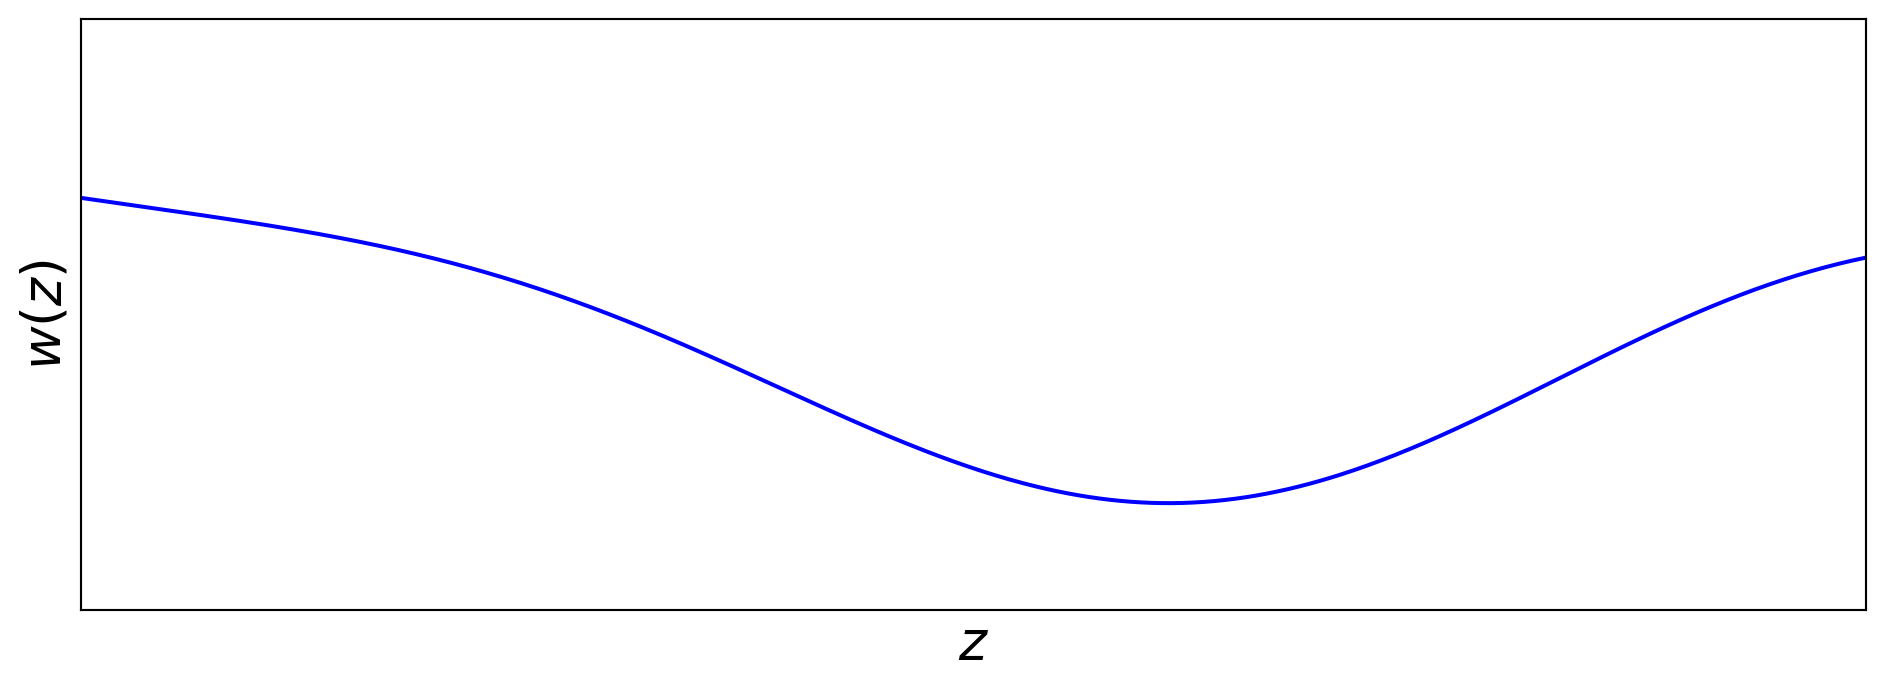

In [10]:
sigma_k = 0.05
kappa = 128
alpha = 0
phi = 0.5
alpha_double = alpha_phi(phi)
scale = 3
seed = 11451

k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
k_cov  = np.diagflat(k_var)

rho = sample_wave_MO(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa, seed=seed)
# z_pos = 0
i_z = np.round(512*(z_pos-(-1))/(1-(-1))).astype(int)
rho_line = rho[0,:,i_z]

fig = plt.figure(figsize=(12,4),dpi=192)
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,rho_line,'b')

ax.set_ylim([-2,2])
ax.set_xlim([-1,1])
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$w(z)$', fontsize=20)